In [6]:
import pandas as pd
df = pd.read_csv('df_cleaned.csv')
df.head()

,City,Customer Age,Customer Name,Customer Segment,Discount,Number of Records,Order Date,Order ID,Order Priority,Order Quantity,...,Region,Row ID,Sales,Ship Date,Ship Mode,Shipping Cost,State,Unit Price,Zip Code,z_score
0,McKeesport,NaN,Jessica Myrick,Small Business,0.10,1,2012-01-01,28774,High,32,...,East,4031,180.36,2012-01-02,Regular Air,4.69,Pennsylvania,5.98,15131,-0.445074
1,Bowie,NaN,Matt Collister,Home Office,0.08,1,2012-01-01,13729,Not Specified,9,...,East,1914,872.48,2012-01-03,Express Air,35.00,Maryland,95.99,20715,-0.252005
2,Napa,NaN,Alan Schoenberger,Corporate,0.00,1,2012-01-02,37537,Low,4,...,West,5272,1239.06,2012-01-02,Delivery Truck,48.80,California,291.73,94559,-0.149747
3,Montebello,NaN,Elizabeth Moffitt,Consumer,0.08,1,2012-01-02,44069,Critical,43,...,West,6225,614.80,2012-01-02,Regular Air,1.97,California,15.04,90640,-0.323886
4,Napa,NaN,Alan Schoenberger,Corporate,0.07,1,2012-01-02,37537,Low,43,...,West,5273,4083.19,2012-01-04,Delivery Truck,45.00,California,100.98,94559,0.643631


C:\Users\deven\AppData\Local\Temp\ipykernel_35836\566389499.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_sales = df.resample('M', on='Order Date')['Sales'].sum()


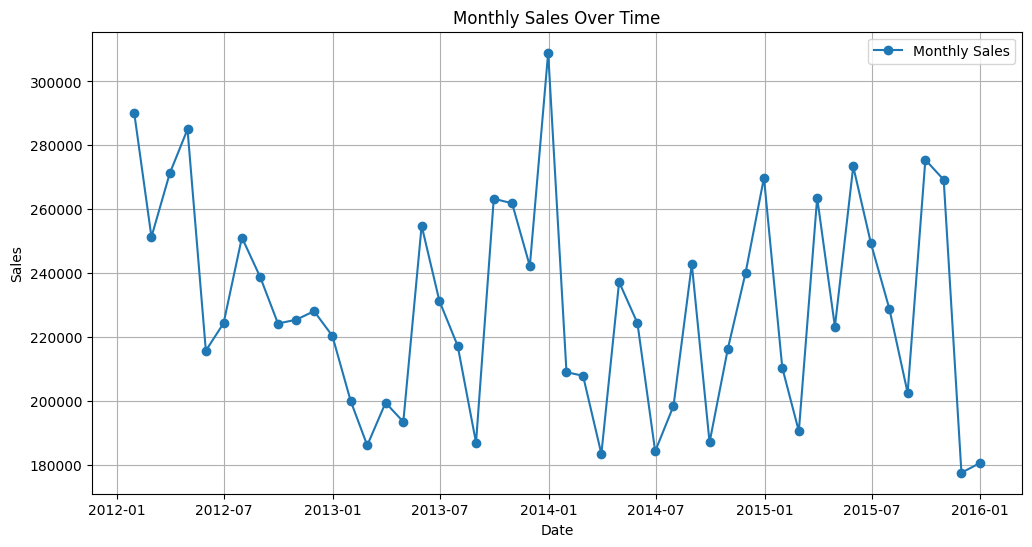

In [7]:

df['Order Date'] = pd.to_datetime(df['Order Date'])
monthly_sales = df.resample('M', on='Order Date')['Sales'].sum()

import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(monthly_sales, marker='o', label='Monthly Sales')
plt.title('Monthly Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()

In [8]:
from statsmodels.tsa.stattools import adfuller


adf_test = adfuller(monthly_sales.dropna())
print("ADF Statistic:", adf_test[0])
print("p-value:", adf_test[1])
print("Critical Values:", adf_test[4])
# data is stationary

ADF Statistic: -5.559918212198157
p-value: 1.5501819385381168e-06
Critical Values: {'1%': -3.5778480370438146, '5%': -2.925338105429433, '10%': -2.6007735310095064}


In [9]:
from pmdarima import auto_arima

arima_model = auto_arima(monthly_sales,
                         seasonal=False,
                         m=12,
                         trace=True,
                         suppress_warnings=True,
                         stepwise=True)


print(arima_model.summary())


C:\Users\deven\myenv\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)


Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=8.46 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1324.161, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=1161.786, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1293.447, Time=1.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=1.87 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=1148.939, Time=2.60 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=1148.965, Time=2.90 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=1148.358, Time=2.25 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=1286.829, Time=0.62 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=1150.940, Time=6.34 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=1286.557, Time=2.03 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=1151.566, Time=17.56 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=1141.524, Time=3.37 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=1140.078, Time=1.28 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=

## ARIMA

C:\Users\deven\AppData\Local\Temp\ipykernel_35836\1311409772.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(monthly_sales.index[-1], periods=n_periods + 1, freq='M')[1:]


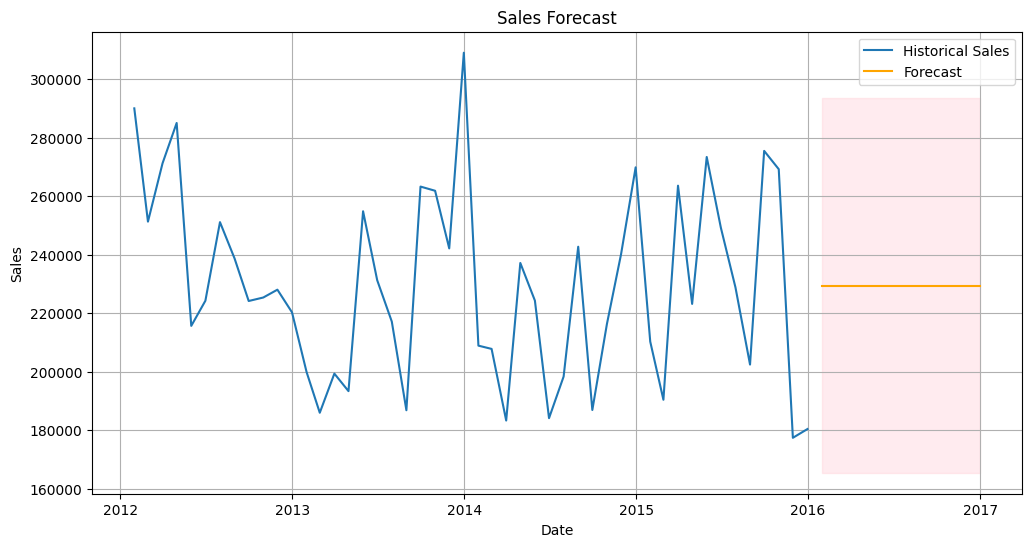

In [10]:

n_periods = 12
forecast, conf_int = arima_model.predict(n_periods=n_periods, return_conf_int=True)


forecast_index = pd.date_range(monthly_sales.index[-1], periods=n_periods + 1, freq='M')[1:]
plt.figure(figsize=(12, 6))
plt.plot(monthly_sales, label='Historical Sales')
plt.plot(forecast_index, forecast, label='Forecast', color='orange')
plt.fill_between(forecast_index,
                 conf_int[:, 0],
                 conf_int[:, 1],
                 color='pink', alpha=0.3)
plt.title('Sales Forecast')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()


In [11]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np


train = monthly_sales[:-12]
test = monthly_sales[-12:]

arima_model.fit(train)

test_forecast = arima_model.predict(n_periods=len(test))


mae = mean_absolute_error(test, test_forecast)
rmse = np.sqrt(mean_squared_error(test, test_forecast))

print("MAE:", mae)
print("RMSE:", rmse)


MAE: 31431.580842592597
RMSE: 35298.75428339379


## SARIMA 

C:\Users\deven\myenv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\deven\myenv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\deven\AppData\Local\Temp\ipykernel_35836\1083525709.py:11: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(monthly_sales.index[-1], periods=12, freq='M')


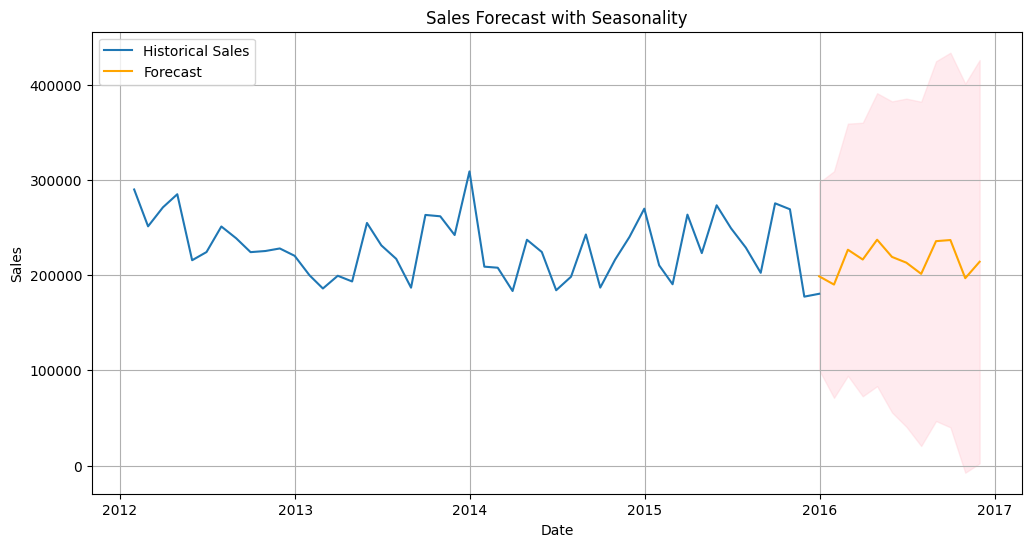

In [12]:
from statsmodels.tsa.statespace.sarimax import SARIMAX


model = SARIMAX(monthly_sales,
                order=(1, 1, 1),
                seasonal_order=(1, 1, 1, 12))
sarima_fit = model.fit()


forecast = sarima_fit.get_forecast(steps=12)
forecast_index = pd.date_range(monthly_sales.index[-1], periods=12, freq='M')
forecast_values = forecast.predicted_mean
conf_int = forecast.conf_int()


import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(monthly_sales, label='Historical Sales')
plt.plot(forecast_index, forecast_values, label='Forecast', color='orange')
plt.fill_between(forecast_index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3)
plt.title('Sales Forecast with Seasonality')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()


## Confusion Matrix

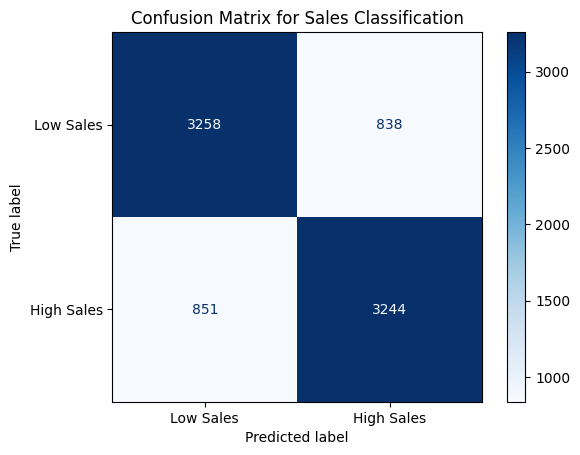

In [13]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Simulate target labels: Low (0) for <= median, High (1) for > median
median_sales = df['Sales'].median()
df['Sales_Class'] = np.where(df['Sales'] > median_sales, 1, 0)

# Simulate predictions (basic logic: misclassify some for demonstration)
np.random.seed(42)
df['Predicted_Class'] = np.where(np.random.rand(len(df)) > 0.2, df['Sales_Class'], 1 - df['Sales_Class'])

# Compute confusion matrix
conf_matrix = confusion_matrix(df['Sales_Class'], df['Predicted_Class'])
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Low Sales', 'High Sales'])

# Plot confusion matrix
disp.plot(cmap='Blues')
plt.title('Confusion Matrix for Sales Classification')
plt.show()

In [14]:
conf_matrix

array([[3258,  838],
       [ 851, 3244]], dtype=int64)

In [15]:
from joblib import dump
dump(model, "sarimax.joblib") 

['sarimax.joblib']

In [5]:
import pandas as pd

# Load the uploaded Walmart dataset
file_path = "walmart.xlsx"

# Read the Excel file
df = pd.read_excel(file_path)

# Display the first few rows to understand the structure
df.head()


,City,Customer Age,Customer Name,Customer Segment,Discount,Number of Records,Order Date,Order ID,Order Priority,Order Quantity,...,Profit,Region,Row ID,Sales,Ship Date,Ship Mode,Shipping Cost,State,Unit Price,Zip Code
0,McKeesport,NaN,Jessica Myrick,Small Business,0.10,1,2012-01-01,28774,High,32,...,-111.80,East,4031,180.36,2012-01-02,Regular Air,4.69,Pennsylvania,5.98,15131
1,Bowie,NaN,Matt Collister,Home Office,0.08,1,2012-01-01,13729,Not Specified,9,...,-342.91,East,1914,872.48,2012-01-03,Express Air,35.00,Maryland,95.99,20715
2,Napa,NaN,Alan Schoenberger,Corporate,0.00,1,2012-01-02,37537,Low,4,...,-193.08,West,5272,1239.06,2012-01-02,Delivery Truck,48.80,California,291.73,94559
3,Montebello,NaN,Elizabeth Moffitt,Consumer,0.08,1,2012-01-02,44069,Critical,43,...,247.79,West,6225,614.80,2012-01-02,Regular Air,1.97,California,15.04,90640
4,Napa,NaN,Alan Schoenberger,Corporate,0.07,1,2012-01-02,37537,Low,43,...,-1049.85,West,5273,4083.19,2012-01-04,Delivery Truck,45.00,California,100.98,94559


In [6]:
# Convert 'Order Date' to datetime format and set as index
df['Order Date'] = pd.to_datetime(df['Order Date'])
df.set_index('Order Date', inplace=True)

# Aggregate sales by date (sum of sales per day)
df_sales = df['Sales'].resample('D').sum()

# Display the first few rows of the processed time series data
df_sales.head()


Order Date
2012-01-01     1052.8400
2012-01-02    11101.8700
2012-01-03    31997.8555
2012-01-04     1254.2500
2012-01-05    39734.4040
Freq: D, Name: Sales, dtype: float64

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Split data: 80% training, 20% testing
train_size = int(len(df_sales) * 0.8)
train, test = df_sales.iloc[:train_size], df_sales.iloc[train_size:]

# Function to calculate evaluation metrics
def evaluate_model(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return mae, mse, rmse, mape

# **1. ARIMA Model**
arima_model = ARIMA(train, order=(2,1,2))  # Adjust (p,d,q) as needed
arima_fit = arima_model.fit()
arima_pred = arima_fit.forecast(steps=len(test))

# **2. SARIMA Model**
sarima_model = SARIMAX(train, order=(2,1,2), seasonal_order=(1,1,1,7))  # Weekly seasonality
sarima_fit = sarima_model.fit()
sarima_pred = sarima_fit.forecast(steps=len(test))

# **3. Prophet Model**
df_prophet = df_sales.reset_index().rename(columns={"Order Date": "ds", "Sales": "y"})
train_prophet = df_prophet.iloc[:train_size]
test_prophet = df_prophet.iloc[train_size:]

prophet_model = Prophet()
prophet_model.fit(train_prophet)
future = prophet_model.make_future_dataframe(periods=len(test))
prophet_pred = prophet_model.predict(future)["yhat"].iloc[train_size:]

# Evaluate Models
arima_metrics = evaluate_model(test.values, arima_pred.values)
sarima_metrics = evaluate_model(test.values, sarima_pred.values)
prophet_metrics = evaluate_model(test.values, prophet_pred.values)

# Create a DataFrame for comparison
metrics_df = pd.DataFrame(
    [arima_metrics, sarima_metrics, prophet_metrics],
    columns=["MAE", "MSE", "RMSE", "MAPE"],
    index=["ARIMA", "SARIMA", "Prophet"]
)

# Display the performance metrics
metrics_df


C:\Users\deven\myenv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\deven\myenv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
17:56:11 - cmdstanpy - INFO - Chain [1] start processing
17:56:12 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\deven\AppData\Local\Temp\ipykernel_14232\4087336267.py:17: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
C:\Users\deven\AppData\Local\Temp\ipykernel_14232\4087336267.py:17: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
C:\Users\deven\AppData\Local\Temp\ipykernel_14232\

,MAE,MSE,RMSE,MAPE
ARIMA,7855.295772,1.166937e+08,10802.486361,inf
SARIMA,8022.715511,1.182288e+08,10873.308705,inf
Prophet,7582.619576,1.178183e+08,10854.411664,inf


In [8]:
metrics_df

,MAE,MSE,RMSE,MAPE
ARIMA,7855.295772,1.166937e+08,10802.486361,inf
SARIMA,8022.715511,1.182288e+08,10873.308705,inf
Prophet,7582.619576,1.178183e+08,10854.411664,inf
